<a href="https://colab.research.google.com/github/Gsdvl/chess-evaluator/blob/test-lstm/chess_evaluation_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Grupo:
    - Débora Noemy de Alcântara Valentim
    - Gabriel Soares Vasconcelos Lira
    - Lucas Loureiro Albuquerque da Silva Eloi

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.utils import resample
import re
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split

## Análise exploratória dos dados ##
 - Os dados foram obtidos no Kaggle, contém informações sobre a avaliação de posições de tabuleiros de xadrez: https://www.kaggle.com/datasets/ronakbadhe/chess-evaluations

Primeiramente, para começarmos a fazer uma análise exploratória para decidir os objetivos, devemos entender a estrutura dos dados com os quais estamos lidando.
Os dados estão divididos em 3 tabelas.
 - chessData contém informações sobre estados de tabuleiros na notação FEN, e a avaliação dele em centipawns (1/100 do valor de um peão)
 - random_evals contém diversos tabuleiros montados aleatoriamente a partir de diversas jogadas, e a avaliação dele em centipawns
 - tactic_evals é similar ao chessData, mas além disso, possui o melhor movimento possível naquele tabuleiro decidido com auxilio da ferramenta Linchess
#### Entender a notação FEN ####
 - A notação FEN é composta por 8 linhas, cada uma contendo peças, em maiusculo para brancas e minusculo para pretas, tendo um número de 1-8 indicando quantas casas vazias entre uma peça e outra. Após isso temos letras para ver a notação sobre de quem é o turno, possibilidade de roques e en passants
#### Centipawns #####
 - Outro fator comum entre todos os datasets é a avaliação do stockfish em centipawns, onde vão existir duas variações, as com # que indicam mate naquela posição, e as sem mate que indicam apenas a avaliação geral do tabuleiro
#### Move ####
 - A base de dados tactic_evals contém uma coluna Move, que contém informações da melhor jogada do Linchess, contendo a cordenada atual e a cordenada futura



In [2]:
# Caminho para o arquivo kaggle.json no ambiente do supercomputador
kaggle_json_path = "kaggle.json"  # Substitua pelo caminho correto

# Configuração do Kaggle
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
os.system(f"cp {kaggle_json_path} ~/.kaggle/")
os.system("chmod 600 ~/.kaggle/kaggle.json")

# Instalação do cliente do Kaggle
!pip install kaggle


In [5]:
# Verifique se o Kaggle está configurado
assert os.path.exists(os.path.expanduser("~/.kaggle/kaggle.json")), "Arquivo kaggle.json não encontrado!"

# Baixe o dataset
!kaggle datasets download -d ronakbadhe/chess-evaluations --unzip -p ./chess_data

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 7, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 414, in authenticate
    self._load_config(config_data)
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 465, in _load_config
    raise ValueError('Error: Missing %s in configuration.' % item)
ValueError: Error: Missing username in configuration.


In [6]:
chessData = pd.read_csv('chess_data/chessData.csv')
random_evals = pd.read_csv('chess_data/random_evals.csv')
tactic_evals = pd.read_csv('chess_data/tactic_evals.csv')

In [7]:
print(chessData.head())
print(random_evals.head())
print(tactic_evals.head())

                                                 FEN Evaluation
0  rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...        -10
1  rnbqkbnr/pppp1ppp/4p3/8/4P3/8/PPPP1PPP/RNBQKBN...        +56
2  rnbqkbnr/pppp1ppp/4p3/8/3PP3/8/PPP2PPP/RNBQKBN...         -9
3  rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPP2PPP/RNBQKB...        +52
4  rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPPN1PPP/R1BQK...        -26
                                                 FEN Evaluation
0  rnbqkb1r/pppppppp/B4n2/8/4P3/8/PPPP1PPP/RNBQK1...       -459
1  rnbqkb1r/pppppppp/5n2/1B6/4P3/8/PPPP1PPP/RNBQK...       -125
2  rnbqkbnr/p1pppppp/8/1p6/4P3/8/PPPP1PPP/RNBQKBN...       +198
3  rnbqkb1r/pppppppp/5n2/8/4P3/7N/PPPP1PPP/RNBQKB...       -155
4  rnbqkbnr/ppppp1pp/8/5p2/4P3/8/PPPP1PPP/RNBQKBN...       +209
                                                 FEN Evaluation  Move
0  r2qkbr1/pb1nn3/1ppp3p/8/3P1p2/2PB1N1P/PPQN1PP1...        #+2  d3g6
1  r2qkb2/pb1nn3/1ppp2rp/8/3P1p2/2P2N1P/PPQN1PP1/...        #+1  c2g6
2  r2qkbr1/pb1nn3/1ppp

In [8]:
data_mates = chessData['Evaluation'][chessData['Evaluation'].str.contains('#', na=False)]
data_mates

,Evaluation
59,#+6
60,#+6
61,#+4
62,#+3
1440,#-19
...,...
1240969,#+3
1240970,#+3
1240971,#+2
1241330,#+5


In [9]:
# Averiguando o comprimento das jogadas, é possível perceber que certos movimentos possuem 5 letras, para representar peões promovidos
dif_len_moves = tactic_evals[tactic_evals['Move'].str.len() != 4]
dif_len_moves

,FEN,Evaluation,Move
62,r2qkb2/pb1nn3/1ppp2Qp/8/3P1p2/2P2N1P/PP1N1PP1/...,#+0,NaN
63,8/7p/5Rp1/2p1pkP1/7P/P4PK1/1r6/3q4 b - - 7 46,#+0,NaN
64,2R2k2/6b1/3N1r1p/r2b2p1/2p5/3p4/P4PPP/2B1R1K1 ...,#+0,NaN
65,k1Q5/pp2p3/2p5/4B3/7q/4N3/PP6/2K5 b - - 0 40,#+0,NaN
66,4R1k1/2q2pp1/5b1p/p4B2/1pN5/1P5P/P4PP1/6K1 b -...,#+0,NaN
...,...,...,...
1392514,r1b1k2r/1pb2ppp/p1N1p3/8/8/4B3/PPP1BPP1/R2QRK1...,#-0,NaN
1392617,rb3rk1/1b3pp1/P3pn1p/4N3/8/PP1B3P/1B3Pq1/R2QR1...,#-0,NaN
1392641,5r2/7k/3Q2p1/pBpP3p/2P5/P2P1P2/3r2q1/4RR1K w -...,#-0,NaN
1392651,5R1k/1np1r1pB/p3P3/1pn3NP/P7/1P6/6P1/6K1 b - -...,#+0,NaN


## Pré-processamento dos dados ##

Formato de um código FEN: rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1

Para utilizar esses dados em um modelo de IA, precisamos fazer algums tratamentos para transformar eles em um input

#### Pré-processamento código FEN ####

- Tokenização: Podemos análisar o código mais facilmente tokenizando o valor para os valores presentes em suas linhas

- Remoção de dados irrelevantes: Para nosso objetivo, que não envolve validação de jogadas, as informações após o tabuleiro não são úteis

- Converter números para 0: Transformar um número naquela quantidade de 0's é importante para representar as casas vazias

- Conversão para matriz: Utilizando a pontuação de sarrat para converter peças em números e transformar o código em uma matriz 8x8

#### Pré-processamento evaluation ####

 - Cheques: Para transformar esses dados em algo mais legível, os cheques serão tratados para existir uma colunas apenas com valores boleanos, se aquele tabuleiro esta com mate ou não, mantendo a coluna de evaluation separada

#### Pré-processamento jogada (tactic_evals) ####

- Tokenização: Similarmente a como fizemos com a notação FEN, para as jogadas, iremos separar os valores em tokens por letra

- Tratar peça extra: Jogadas que envolvem promoções de peões, possuem um algarismo a mais denotando a peça para a qual ele foi promovido, portanto, irei realizar a substituição dessa peça, pela pontuação de sarrat equivalente, e acrecentar um valor 0 ao final dos tokens que não possuem ela para manter as entradas no mesmo formato sem ter perca de informação

- Conversão tokens: Para simplificar o entendimento pelo modelo, não seria um problema para a notação, substituir o valor das letras, por seu equivalente numérico, que na prática é a mesma coisa nesse contexto



In [10]:
checkmate_rows = chessData[chessData['Evaluation'].str.contains('#')]
non_checkmate_rows = chessData[~chessData['Evaluation'].str.contains('#')]

print(f"Número de Checkmates: {len(checkmate_rows)}")
print(f"Número de Não Checkmates: {len(non_checkmate_rows)}")


Número de Checkmates: 10742
Número de Não Checkmates: 1230626


In [11]:
# Subamostrar a classe Não Checkmate
non_checkmate_sampled = resample(
    non_checkmate_rows,
    replace=False,
    n_samples=len(checkmate_rows),  # Igualar ao número de Checkmates
    random_state=42
)

# Combinar as classes balanceadas
balanced_data = pd.concat([checkmate_rows, non_checkmate_sampled])

# Misturar as amostras
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)


In [12]:
balanced_data

,FEN,Evaluation
0,2b2r1k/1p4p1/2q1B1Qp/p1b3N1/P2p3P/1P4P1/1B2R1K...,#+5
1,3r2k1/1pp3p1/p5q1/P1p1p3/2P3pb/1P2rP2/3NK3/3RR...,#-3
2,2r3k1/1pr1ppbp/1q1p2p1/p1nP4/4P3/PP2BP2/2RQB1P...,+348
3,7k/1p3p1r/3q1p2/2p5/1n6/6PQ/3P1P1P/4R1K1 w - -...,#+8
4,8/1k6/R7/8/PPK5/8/8/8 w - - 3 70,#+8
...,...,...
21479,8/8/8/2B5/p7/6b1/k1K5/8 b - - 3 73,-9
21480,3r4/8/8/8/R1p1K3/P1P5/1Pk5/8 b - - 0 65,0
21481,1k5r/2p5/BpPp2p1/3Pp1q1/pQ2Pr1p/7P/PP3R1K/5R1N...,#+9
21482,5rk1/2Q3p1/1p1p4/3PpP1p/2P1q3/2B1b1PK/PP5P/4R3...,#-6


In [13]:
#Reduzindo o tamanho dos dados para ser gentil com meu notebook
# chessData = chessData[0:500000]
# tactic_evals = tactic_evals[0:500]

In [14]:
tactic_evals = tactic_evals.dropna()

In [15]:
sarrat = {
    'P':1,
    'N':3.1,
    'B':3.3,
    'R':5,
    'Q':7.9,
    'K':2.2,
    'p':-1,
    'n':-3.1,
    'b':-3.3,
    'r':-5,
    'q':-7.9,
    'k':-2.2,
    '0': 0
}
letters = ['a','b','c','d','e','f','g','h']

In [16]:
# Operações para tratar boards
def separate_board(board):
    return board['FEN'].apply(lambda x: x.replace('/', ' ').split()).tolist()

def remove_extras(board):
    return [row[:8] for row in board]

def num_to_zeros(board):
    return [
        [re.sub(r'[1-9]', lambda x: '0' * int(x.group()), cell) if isinstance(cell, str) else cell for cell in row]
        for row in board
    ]

def fen_to_matrix(board):
    if isinstance(board, pd.DataFrame):
        board = board.iloc[:, 0].tolist()

    matrix = []
    for row in board:
        row_a = []
        for piece in row:
            if piece in sarrat:
                row_a.append(sarrat[piece])
            else:
                row_a.append(0)
        matrix.append(row_a)
    return matrix

def fen_in_column(board_column):
    return [fen_to_matrix(row) for row in board_column]


#Operações para tratar movimentos

def separate_move(move):
    return [list(i) for i in move]


def normalize_size(move):
    norm_moves = []
    for row in move:
        if len(row) == 4:
            row.append('0')
        norm_moves.append(row)
    return norm_moves



def coords_to_numbers(moves):
    num_moves = []
    for cord in moves:
        num_move = []
        for i in cord:
            if i in letters:
                num_move.append(letters.index(i))
            elif i.isdigit():
                num_move.append(int(i) - 1)
        num_moves.append(num_move)
    return num_moves


#Operações para evaluation

def mate_column(evaluation):
    return ('#' in evaluation)



In [17]:
pipeline_transform_fen = Pipeline([
    ('Separate board into lines', FunctionTransformer(separate_board)),
    ('Remove no-board info', FunctionTransformer(remove_extras)),
    ('Convert num to zeros', FunctionTransformer(num_to_zeros)),
    ('Convert fen notation to matrix', FunctionTransformer(fen_in_column))
])

In [18]:
pipeline_transform_move = Pipeline([
    ('Separate move', FunctionTransformer(separate_move)),
    ('Normalize size', FunctionTransformer(normalize_size)),
    ('Convert coords to numbers', FunctionTransformer(coords_to_numbers))
])

In [19]:
cleared_chess_data = balanced_data.copy()

print(cleared_chess_data['FEN'].head())
cleared_chess_data['FEN'] = pipeline_transform_fen.fit_transform(cleared_chess_data[['FEN']])

cleared_chess_data['MATE'] = cleared_chess_data['Evaluation'].apply(mate_column)
cleared_chess_data.head()

0    2b2r1k/1p4p1/2q1B1Qp/p1b3N1/P2p3P/1P4P1/1B2R1K...
1    3r2k1/1pp3p1/p5q1/P1p1p3/2P3pb/1P2rP2/3NK3/3RR...
2    2r3k1/1pr1ppbp/1q1p2p1/p1nP4/4P3/PP2BP2/2RQB1P...
3    7k/1p3p1r/3q1p2/2p5/1n6/6PQ/3P1P1P/4R1K1 w - -...
4                     8/1k6/R7/8/PPK5/8/8/8 w - - 3 70
Name: FEN, dtype: object


,FEN,Evaluation,MATE
0,"[[0, 0, -3.3, 0, 0, -5, 0, -2.2], [0, -1, 0, 0...",#+5,True
1,"[[0, 0, 0, -5, 0, 0, -2.2, 0], [0, -1, -1, 0, ...",#-3,True
2,"[[0, 0, -5, 0, 0, 0, -2.2, 0], [0, -1, -5, 0, ...",+348,False
3,"[[0, 0, 0, 0, 0, 0, 0, -2.2], [0, -1, 0, 0, 0,...",#+8,True
4,"[[0, 0, 0, 0, 0, 0, 0, 0], [0, -2.2, 0, 0, 0, ...",#+8,True


## TENTATIVA COM RNN

In [28]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Função para dividir o FEN em linhas
def split_fen_into_lines(fen):
    clean_fen = fen.split(' ')[0]  # Pega apenas o tabuleiro, removendo os metadados finais
    return clean_fen.split('/')  # Divide o tabuleiro em 8 linhas  # Cada linha do tabuleiro é separada por '/'

# Exemplo
exemplo_fen = "4r3/1p2k1pp/r1p5/p1n5/P1P1Pp2/2N2P2/1PR2K1P/6R1 b - - 1 28"
print(split_fen_into_lines(exemplo_fen))


['4r3', '1p2k1pp', 'r1p5', 'p1n5', 'P1P1Pp2', '2N2P2', '1PR2K1P', '6R1']


In [29]:
balanced_data

,FEN,Evaluation
0,2b2r1k/1p4p1/2q1B1Qp/p1b3N1/P2p3P/1P4P1/1B2R1K...,#+5
1,3r2k1/1pp3p1/p5q1/P1p1p3/2P3pb/1P2rP2/3NK3/3RR...,#-3
2,2r3k1/1pr1ppbp/1q1p2p1/p1nP4/4P3/PP2BP2/2RQB1P...,+348
3,7k/1p3p1r/3q1p2/2p5/1n6/6PQ/3P1P1P/4R1K1 w - -...,#+8
4,8/1k6/R7/8/PPK5/8/8/8 w - - 3 70,#+8
...,...,...
21479,8/8/8/2B5/p7/6b1/k1K5/8 b - - 3 73,-9
21480,3r4/8/8/8/R1p1K3/P1P5/1Pk5/8 b - - 0 65,0
21481,1k5r/2p5/BpPp2p1/3Pp1q1/pQ2Pr1p/7P/PP3R1K/5R1N...,#+9
21482,5rk1/2Q3p1/1p1p4/3PpP1p/2P1q3/2B1b1PK/PP5P/4R3...,#-6


In [30]:
processed_data = balanced_data.copy()

processed_data['FEN_Lines'] = processed_data['FEN'].apply(split_fen_into_lines)

processed_data['MATE'] = processed_data['Evaluation'].apply(mate_column)

print(processed_data[['FEN', 'FEN_Lines']].head())

                                                 FEN  \
0  2b2r1k/1p4p1/2q1B1Qp/p1b3N1/P2p3P/1P4P1/1B2R1K...   
1  3r2k1/1pp3p1/p5q1/P1p1p3/2P3pb/1P2rP2/3NK3/3RR...   
2  2r3k1/1pr1ppbp/1q1p2p1/p1nP4/4P3/PP2BP2/2RQB1P...   
3  7k/1p3p1r/3q1p2/2p5/1n6/6PQ/3P1P1P/4R1K1 w - -...   
4                   8/1k6/R7/8/PPK5/8/8/8 w - - 3 70   

                                           FEN_Lines  
0  [2b2r1k, 1p4p1, 2q1B1Qp, p1b3N1, P2p3P, 1P4P1,...  
1  [3r2k1, 1pp3p1, p5q1, P1p1p3, 2P3pb, 1P2rP2, 3...  
2  [2r3k1, 1pr1ppbp, 1q1p2p1, p1nP4, 4P3, PP2BP2,...  
3  [7k, 1p3p1r, 3q1p2, 2p5, 1n6, 6PQ, 3P1P1P, 4R1K1]  
4                     [8, 1k6, R7, 8, PPK5, 8, 8, 8]  


In [31]:
processed_data

,FEN,Evaluation,FEN_Lines,MATE
0,2b2r1k/1p4p1/2q1B1Qp/p1b3N1/P2p3P/1P4P1/1B2R1K...,#+5,"[2b2r1k, 1p4p1, 2q1B1Qp, p1b3N1, P2p3P, 1P4P1,...",True
1,3r2k1/1pp3p1/p5q1/P1p1p3/2P3pb/1P2rP2/3NK3/3RR...,#-3,"[3r2k1, 1pp3p1, p5q1, P1p1p3, 2P3pb, 1P2rP2, 3...",True
2,2r3k1/1pr1ppbp/1q1p2p1/p1nP4/4P3/PP2BP2/2RQB1P...,+348,"[2r3k1, 1pr1ppbp, 1q1p2p1, p1nP4, 4P3, PP2BP2,...",False
3,7k/1p3p1r/3q1p2/2p5/1n6/6PQ/3P1P1P/4R1K1 w - -...,#+8,"[7k, 1p3p1r, 3q1p2, 2p5, 1n6, 6PQ, 3P1P1P, 4R1K1]",True
4,8/1k6/R7/8/PPK5/8/8/8 w - - 3 70,#+8,"[8, 1k6, R7, 8, PPK5, 8, 8, 8]",True
...,...,...,...,...
21479,8/8/8/2B5/p7/6b1/k1K5/8 b - - 3 73,-9,"[8, 8, 8, 2B5, p7, 6b1, k1K5, 8]",False
21480,3r4/8/8/8/R1p1K3/P1P5/1Pk5/8 b - - 0 65,0,"[3r4, 8, 8, 8, R1p1K3, P1P5, 1Pk5, 8]",False
21481,1k5r/2p5/BpPp2p1/3Pp1q1/pQ2Pr1p/7P/PP3R1K/5R1N...,#+9,"[1k5r, 2p5, BpPp2p1, 3Pp1q1, pQ2Pr1p, 7P, PP3R...",True
21482,5rk1/2Q3p1/1p1p4/3PpP1p/2P1q3/2B1b1PK/PP5P/4R3...,#-6,"[5rk1, 2Q3p1, 1p1p4, 3PpP1p, 2P1q3, 2B1b1PK, P...",True


In [32]:
# Inicializar o tokenizador no nível de caracteres
tokenizer = Tokenizer(char_level=True, oov_token='UNK')  # oov_token para tokens desconhecidos

# Preparar todas as linhas para treinamento
all_lines = [line for lines in processed_data['FEN_Lines'] for line in lines]  # Flatten da lista

# Ajustar o tokenizador ao conjunto de linhas
tokenizer.fit_on_texts(all_lines)

# Converter as linhas FEN em sequências numéricas
processed_data['FEN_Tokens'] = processed_data['FEN_Lines'].apply(
    lambda lines: tokenizer.texts_to_sequences(lines)
)

# Exibir exemplo da tokenização
print("Exemplo de tokenização:")
print(processed_data[['FEN_Lines', 'FEN_Tokens']].head())

Exemplo de tokenização:
                                           FEN_Lines  \
0  [2b2r1k, 1p4p1, 2q1B1Qp, p1b3N1, P2p3P, 1P4P1,...   
1  [3r2k1, 1pp3p1, p5q1, P1p1p3, 2P3pb, 1P2rP2, 3...   
2  [2r3k1, 1pr1ppbp, 1q1p2p1, p1nP4, 4P3, PP2BP2,...   
3  [7k, 1p3p1r, 3q1p2, 2p5, 1n6, 6PQ, 3P1P1P, 4R1K1]   
4                     [8, 1k6, R7, 8, PPK5, 8, 8, 8]   

                                          FEN_Tokens  
0  [[4, 8, 4, 5, 3, 7], [3, 2, 9, 2, 3], [4, 11, ...  
1  [[6, 5, 4, 7, 3], [3, 2, 2, 6, 2, 3], [2, 12, ...  
2  [[4, 5, 6, 7, 3], [3, 2, 5, 3, 2, 2, 8, 2], [3...  
3  [[15, 7], [3, 2, 6, 2, 3, 5], [6, 11, 3, 2, 4]...  
4  [[13], [3, 7, 14], [5, 15], [13], [2, 2, 7, 12...  


In [33]:
# Definir o comprimento máximo para padding
max_len = max(len(line) for lines in processed_data['FEN_Tokens'] for line in lines)

# Aplicar padding em todas as linhas
processed_data['FEN_Padded'] = processed_data['FEN_Tokens'].apply(
    lambda lines: pad_sequences(lines, maxlen=max_len, padding='post')
)

# Exibir o resultado final
print("Exemplo com padding:")
print(processed_data[['FEN_Tokens', 'FEN_Padded']].head())


Exemplo com padding:
                                          FEN_Tokens  \
0  [[4, 8, 4, 5, 3, 7], [3, 2, 9, 2, 3], [4, 11, ...   
1  [[6, 5, 4, 7, 3], [3, 2, 2, 6, 2, 3], [2, 12, ...   
2  [[4, 5, 6, 7, 3], [3, 2, 5, 3, 2, 2, 8, 2], [3...   
3  [[15, 7], [3, 2, 6, 2, 3, 5], [6, 11, 3, 2, 4]...   
4  [[13], [3, 7, 14], [5, 15], [13], [2, 2, 7, 12...   

                                          FEN_Padded  
0  [[4, 8, 4, 5, 3, 7, 0, 0], [3, 2, 9, 2, 3, 0, ...  
1  [[6, 5, 4, 7, 3, 0, 0, 0], [3, 2, 2, 6, 2, 3, ...  
2  [[4, 5, 6, 7, 3, 0, 0, 0], [3, 2, 5, 3, 2, 2, ...  
3  [[15, 7, 0, 0, 0, 0, 0, 0], [3, 2, 6, 2, 3, 5,...  
4  [[13, 0, 0, 0, 0, 0, 0, 0], [3, 7, 14, 0, 0, 0...  


In [34]:
X_lstm = np.array([
    np.concatenate(padded_lines) for padded_lines in processed_data['FEN_Padded']
])
y_lstm = processed_data['MATE'].to_numpy()  # Rótulo binário

# Certifique-se que a forma está correta
print(f"Formato corrigido de X_lstm: {X_lstm.shape}")  # Deve ser (n_amostras, sequence_length)
print(f"Tipo de dados: {X_lstm.dtype}")
print(f"Formato dos rótulos: {y_lstm.shape}")


Formato corrigido de X_lstm: (21484, 64)
Tipo de dados: int32
Formato dos rótulos: (21484,)


In [35]:
X_lstm = X_lstm.reshape((X_lstm.shape[0], X_lstm.shape[1], 1))  # Adiciona uma dimensão para features


In [36]:
X_lstm = X_lstm.astype('float32')


In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Definir o tamanho do vocabulário e comprimento da sequência
vocab_size = len(np.unique(X_lstm)) + 1  # Soma 1 para incluir o índice de padding
sequence_length = X_lstm.shape[1]  # Comprimento das sequências (64)

# Construir o modelo LSTM
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=32, input_length=sequence_length),  # Embedding Layer
    LSTM(64, return_sequences=True),  # Primeira camada LSTM (retorna sequências)
    Dropout(0.3),
    LSTM(64, return_sequences=False),  # Segunda camada LSTM
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Camada de saída para classificação binária
])

# Compilar o modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Resumo do modelo
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 64, 32)            512       
                                                                 
 lstm (LSTM)                 (None, 64, 64)            24832     
                                                                 
 dropout (Dropout)           (None, 64, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)


In [40]:
# Treinamento do modelo
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
430/430 [==============================] - 25s 52ms/step - loss: 0.5554 - accuracy: 0.7170 - val_loss: 0.5369 - val_accuracy: 0.7403
Epoch 2/10
430/430 [==============================] - 23s 54ms/step - loss: 0.5099 - accuracy: 0.7552 - val_loss: 0.5018 - val_accuracy: 0.7542
Epoch 3/10
430/430 [==============================] - 23s 53ms/step - loss: 0.4986 - accuracy: 0.7583 - val_loss: 0.4894 - val_accuracy: 0.7641
Epoch 4/10
430/430 [==============================] - 21s 49ms/step - loss: 0.4888 - accuracy: 0.7686 - val_loss: 0.4715 - val_accuracy: 0.7737
Epoch 5/10
430/430 [==============================] - 23s 54ms/step - loss: 0.4806 - accuracy: 0.7678 - val_loss: 0.4568 - val_accuracy: 0.7746
Epoch 6/10
430/430 [==============================] - 21s 50ms/step - loss: 0.4720 - accuracy: 0.7769 - val_loss: 0.4518 - val_accuracy: 0.7856
Epoch 7/10
430/430 [==============================] - 22s 51ms/step - loss: 0.4665 - accuracy: 0.7757 - val_loss: 0.4478 - val_accuracy:

In [41]:
# Avaliação do modelo
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Loss: {loss}, Accuracy: {accuracy}")


135/135 [==============================] - 2s 17ms/step - loss: 0.4339 - accuracy: 0.7936
Loss: 0.4339213967323303, Accuracy: 0.7935768961906433


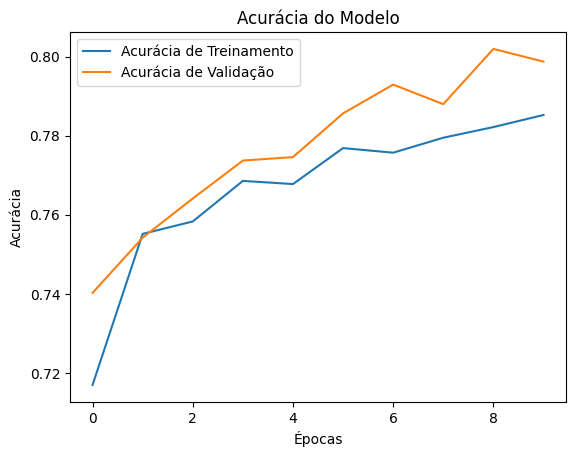

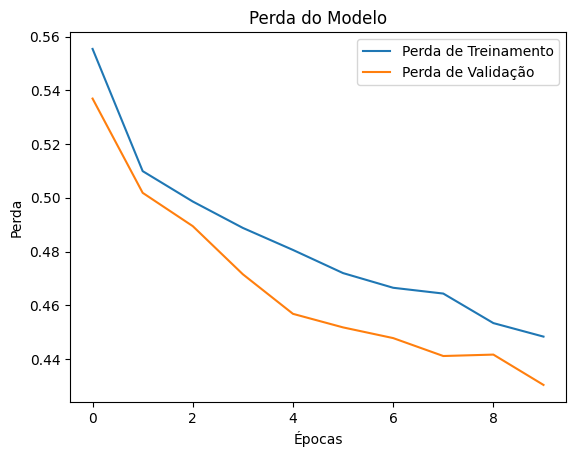

In [42]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Acurácia de Treinamento')
plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
plt.title('Acurácia do Modelo')
plt.ylabel('Acurácia')
plt.xlabel('Épocas')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Perda de Treinamento')
plt.plot(history.history['val_loss'], label='Perda de Validação')
plt.title('Perda do Modelo')
plt.ylabel('Perda')
plt.xlabel('Épocas')
plt.legend()
plt.show()


In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [44]:
# Fazendo previsões no conjunto de teste
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)  # Converte as probabilidades em classes


135/135 [==============================] - 3s 17ms/step


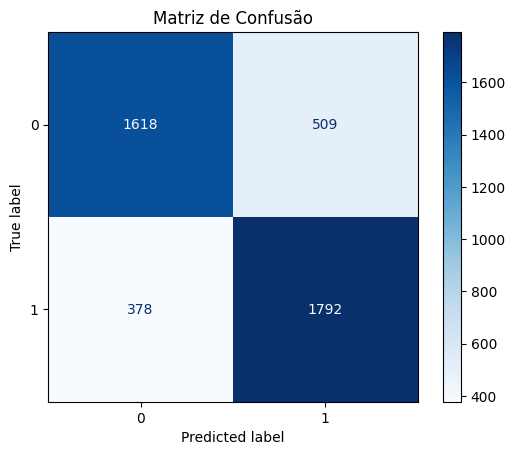

In [45]:
# Criar a matriz de confusão
cm = confusion_matrix(y_test, y_pred_classes)

# Visualizar a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.show()
